### Information extraction from bordered and semi-bordered (only horizontal borders) table images

In [ ]:
# Installations
! apt install tesseract-ocr
! apt install libtesseract-dev
! pip install Pillow
! pip install pytesseract


In [ ]:
#Imports

import cv2
import matplotlib.pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow
import pandas as pd
import csv

try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract

#### 1. Bordered tables

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from google.colab.patches import cv2_imshow

try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract

def convertTableImageToCsv(filename):
  #read your file
  filenameComp = filename.split('.')
  img_bin, img = getInvertedImage(filename)
  vertical_lines, horizontal_lines, kernel = getVerAndHorLines(img_bin)
  img_vh, contours = getSkeleton(vertical_lines, horizontal_lines, kernel)
  bitxor = cv2.bitwise_xor(img,img_vh)
  bitnot = cv2.bitwise_not(bitxor)
  contours, boundingBoxes = sort_contours(contours, method="top-to-bottom")
  contours = contours[2:]
  boxes, mean = getBoxes(contours,boundingBoxes, img)
  finalboxes, row, countcol = arrangeBoxes(boxes, mean)
  finalOutputArray = getFinalOutputArray(finalboxes, bitnot)
  exportToExcel(finalOutputArray, row, countcol,filenameComp)



def exportToExcel(outer, row, countcol,filenameComp):
  #Creating a dataframe of the generated OCR list
  arr = np.array(outer)
  dataframe = pd.DataFrame(arr.reshape(len(row), countcol), index=None)
  print(dataframe) 
  data = dataframe.style.set_properties(align="left")
  #Converting it in a excel-file
  data.to_excel(filenameComp[0] + '_output.xlsx')

def getInvertedImage(filename):
  # filename = 'table4.png'
  filenameComp = filename.split('.')
  img = cv2.imread(filename,0)

  #thresholding the image to a binary image
  thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)

  #inverting the image 
  img_bin = 255-img_bin
  cv2.imwrite(filenameComp[0] + '_inverted.png',img_bin)
  return img_bin,img
  #Plotting the image to see the output
  # plotting = plt.imshow(img_bin,cmap='gray')
  # plt.show()

def getVerAndHorLines(img_bin):
  kernel_len = np.array(img_bin).shape[1]//100
  # Defining a vertical kernel to detect all vertical lines of image 
  ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
  # Defining a horizontal kernel to detect all horizontal lines of image
  hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
  # A kernel of 2x2
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
  #Use vertical kernel to detect and save the vertical lines in a jpg
  image_1 = cv2.erode(img_bin, ver_kernel, iterations=10)
  vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=10)
  cv2.imwrite("vertical.jpg",vertical_lines)
  #Plot the generated image
  # plotting = plt.imshow(vertical_lines,cmap='gray')
  # plt.show()

  #Use horizontal kernel to detect and save the horizontal lines in a jpg
  image_2 = cv2.erode(img_bin, hor_kernel, iterations=10)
  horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=10)
  cv2.imwrite("horizontal.jpg",horizontal_lines)
  #Plot the generated image
  # plotting = plt.imshow(horizontal_lines,cmap='gray')
  # plt.show()

  return vertical_lines, horizontal_lines, kernel

def getSkeleton(vertical_lines, horizontal_lines, kernel):
  ver_contours, ver_line_hierarchy = cv2.findContours(vertical_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  hor_contours, hor_line_hierarchy = cv2.findContours(horizontal_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  total_cells  = (len(ver_contours) - 1) * (len(hor_contours) - 1)
  optimumContoursObtained = False
  offset = -1

  while not optimumContoursObtained:
    rows,cols = horizontal_lines.shape
    M = np.float32([[1,0,offset],[0,1,0]])
    horizontal_lines = cv2.warpAffine(horizontal_lines,M,(cols,rows))

    rows,cols = vertical_lines.shape
    M = np.float32([[1,0,0],[0,1,offset]])
    vertical_lines = cv2.warpAffine(vertical_lines,M,(cols,rows))
    # Combine horizontal and vertical lines in a new third image, with both having same weight.
    img_vh = cv2.addWeighted(vertical_lines, 1, horizontal_lines, 1, 0.0)
    #Eroding and thesholding the image
    img_vh = cv2.erode(~img_vh, kernel, iterations=2)
    thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # print(len(contours) - 2)

    if (len(contours) - 2) == total_cells:
      optimumContoursObtained = True
    else:
      offset = offset - 0.5

  return img_vh, contours

def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

def getBoxes(contours,boundingBoxes,img):
  #Creating a list of heights for all detected boxes
  heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]

  #Get mean of heights
  mean = np.mean(heights)

  #Create list box to store all boxes in  
  box = []
  # Get position (x,y), width and height for every contour and show the contour on image
  for c in contours:
      x, y, w, h = cv2.boundingRect(c)
      if (w<1000 and h<500):
          image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
          box.append([x,y,w,h])
          
  # plotting = plt.imshow(image,cmap='gray')
  # plt.show()
  return box, mean

def arrangeBoxes(box, mean):
  #Creating two lists to define row and column in which cell is located
  row=[]
  column=[]
  j=0

  #Sorting the boxes to their respective row and column
  for i in range(len(box)):    
          
      if(i==0):
          column.append(box[i])
          previous=box[i]    
      
      else:
          if(box[i][1]<=previous[1]+mean/2):
              column.append(box[i])
              previous=box[i]            
              
              if(i==len(box)-1):
                  row.append(column)        
              
          else:
              row.append(column)
              column=[]
              previous = box[i]
              column.append(box[i])
              
  # print(column)
  # print(row)

  #calculating maximum number of cells
  countcol = 0
  for i in range(len(row)):
      countcol = len(row[i])
      if countcol > countcol:
          countcol = countcol
  #Retrieving the center of each column
  center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]

  center=np.array(center)
  center.sort()
  # print(center)
  #Regarding the distance to the columns center, the boxes are arranged in respective order

  finalboxes = []
  for i in range(len(row)):
      lis=[]
      for k in range(countcol):
          lis.append([])
      for j in range(len(row[i])):
          diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
          minimum = min(diff)
          indexing = list(diff).index(minimum)
          lis[indexing].append(row[i][j])
      finalboxes.append(lis)
  
  return finalboxes, row, countcol

def getFinalOutputArray(finalboxes, bitnot):
  #from every single image-based cell/box the strings are extracted via pytesseract and stored in a list
  outer=[]
  for i in range(len(finalboxes)):
      for j in range(len(finalboxes[i])):
          inner=''
          if(len(finalboxes[i][j])==0):
              outer.append(' ')
          else:
              for k in range(len(finalboxes[i][j])):
                  y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                  finalimg = bitnot[x:x+h, y:y+w]
                  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                  border = cv2.copyMakeBorder(finalimg,1,1,1,1, cv2.BORDER_CONSTANT,value=[255,255])
                  resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                  # cv2_imshow(resizing)
                  # dilation = cv2.dilate(resizing, kernel,iterations=1)
                  # erosion = cv2.erode(dilation, kernel,iterations=3)
                  opening = cv2.morphologyEx(resizing, cv2.MORPH_OPEN, kernel)
                  # opening = erosion
                  _, th1 = cv2.threshold(opening,175,255,cv2.THRESH_BINARY)
                  # cv2_imshow(erosion)
                  # cv2_imshow(finalimg)
                  # cv2_imshow(th1)
                  out = pytesseract.image_to_string(th1,  lang = 'eng', config='--psm 6 --oem 3', output_type='string')
                  # out = out if out != ': |' else ''
                  # print(out)
                  if(len(out)==0):
                      out = pytesseract.image_to_string(th1, config='--psm 3')
                  inner = inner +" "+ out
                  # print(inner)
              outer.append(inner)
  
  return outer

In [ ]:
# Run for bordered tables
# convertTableImageToCsv(<table image name>)
borderedTableImage = ''
convertTableImageToCsv(borderedTableImage))

### 2. Non-Bordered Tables

There are 2 steps for a non-bordered table image.

The program essentially works on table images where the horizontal borders are present.

We define and draw the vertical lines, ultimately converting it to a bordered table.

We then execute the program for bordered tables.

In [ ]:
def getHorizontalLines(edges,img):

  initialAdj = 100
  lines = None
  while lines is None:
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=(img.shape[1]-initialAdj), maxLineGap=10)
    initialAdj += 25

  return lines

def addOuterBorders(img, filenameComp):
  from google.colab.patches import cv2_imshow
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  edges = cv2.Canny(gray, 50,150, apertureSize=3)
  # lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=(img.shape[1]-200), maxLineGap=10)
  lines = getHorizontalLines(edges,img)
  pt1_x = pt1_y = pt2_x = pt2_y = pt3_x = pt3_y = pt4_x = pt4_y = 0

  first = True
  currLineCor = []
  yCor_line_map = {}

  for line in lines:
    x1,y1,x2,y2 = line[0]
    currLineCor = [x1,y1,x2,y2]
    if first or currLineCor[1] < pt1_y:
      pt1_x = x1
      pt1_y = y1
      pt2_x= x2
      pt2_y = y2
      first  = False

    cv2.line(img, (x1,y1), (x2,y2), (0,0,0),1)
    yCor_line_map[y1] = currLineCor

    if currLineCor[1] > pt3_y:
      pt3_x = x1
      pt3_y = y1
      pt4_x= x2
      pt4_y = y2

  cv2.line(img, (pt1_x,pt1_y), (pt3_x,pt3_y), (0,0,0),1)
  cv2.line(img, (pt2_x,pt2_y), (pt4_x,pt4_y), (0,0,0),1)
  cv2_imshow(img)
  cv2.imwrite(filenameComp[0] + '_ext_bordered.png', img) 
  return img, yCor_line_map


def getColDelimiters(img, yCor_line_map,filenameComp):
  
  header_yCor = sorted(yCor_line_map)[1:4:2]
  crop_img = img[header_yCor[0]:header_yCor[1], 0:img.shape[1]]
  cv2_imshow(crop_img)
  cv2.imwrite(filenameComp[0] + '_cropped_header.png', crop_img)
  crop_img = cv2.imread(filenameComp[0] + '_cropped_header.png',0)
  _, extreme_img = cv2.threshold(crop_img,100,255,cv2.THRESH_BINARY)
  # import pandas as pd
  # extImgDf = pd.DataFrame(extreme_img)
  middle_x = extreme_img.shape[0]//2

  rowImage = extreme_img

  contWhitePixelCount = 0
  firstLetterPassed = False
  delimiters = []
  colEnded = False

  def IsNotALetter(pixel_index):
    notALetter = True

    for x in range(5):
      if rowImage[(middle_x - x), pixel_index] == 0 or rowImage[(middle_x + x),pixel_index] == 0 :
        notALetter = False
        break

    return notALetter

  for pixel_index, pixel in enumerate(rowImage[middle_x,:]):

    if contWhitePixelCount > 13:
      
      if IsNotALetter(pixel_index) :
        colEnded = True
      else:
        contWhitePixelCount = 0
    
    if firstLetterPassed and pixel == 255:
      contWhitePixelCount += 1
    elif pixel == 0:
      contWhitePixelCount = 0

      if not firstLetterPassed and pixel_index > 6:
        firstLetterPassed = True

      if colEnded:
        delimiters.append(pixel_index - 10)
        colEnded = False

  return delimiters


def get_bordered_Image(delimiters, yCor_line_map, img):
  offsets = []
  offsets.append(yCor_line_map[sorted(yCor_line_map.keys())[0]][1])
  offsets.append(yCor_line_map[sorted(yCor_line_map.keys())[-1]][1])

  for delimiter in delimiters:
    cv2.line(img, (delimiter,offsets[0]), (delimiter, offsets[1]), (0,0,0),1)

  return img



In [ ]:
from google.colab import files
files.upload()

Saving tab_hor2.png to tab_hor2.png
Saving tab_hor3.png to tab_hor3.png
Saving tab_hor4.png to tab_hor4.png
Saving tab_hor6.png to tab_hor6.png
Saving tab_hor8.png to tab_hor8.png


{'tab_hor2.png': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01v\x00\x00\x01-\x08\x02\x00\x00\x00\x93u\xdc\x06\x00\x00\x00\x01sRGB\x00\xae\xce\x1c\xe9\x00\x00\x00\x04gAMA\x00\x00\xb1\x8f\x0b\xfca\x05\x00\x00\x00\tpHYs\x00\x00\x0e\xc3\x00\x00\x0e\xc3\x01\xc7o\xa8d\x00\x00\x1b\x16IDATx^\xed\x9dmb\xec\xa6\x0e@\xbb\xae,(\xeb\xc9j\xba\x99.\xe6=\x84\xf8\x900\x93\xeb\x1b#O\x869\xe7G\x0b\x02$!\x842\x99\xc6\xee?\xff\x03\x00\x08\x83\x12\x03\x00\x81Pb\x00 \x10J\x0c\x00\x04B\x89\x01\x80@(1\x00\x10\x08%\x06\x00\x02\xa1\xc4\x00@ \x94\x18\x00\x08\x84\x12\x03\x00\x81Pb\x00 \x10J\x0c\x00\x04B\x89\x01\x80@(1\x00\x10\x08%\x06\x00\x02\xa1\xc4\x00@ \x94\x18\x00\x08\x84\x12\x03\x00\x81Pb\x00 \x10J\x0c\x00\x04B\x89\x01\x80@(1\x00\x10\x08%\x06\x00\x02\xa1\xc4\x00@ \x94\x18\x00\x08\x84\x12\x03\x00\x81Pb\x00 \x10J\x0c\x00\x04B\x89\x01\x80@(1\x00\x10\x08%\x06\x00\x02\xa1\xc4\x00@ \x94\x18\x00\x08\x84\x12\x03\x00\x81Pb\x00 \x10J\x0c\x00\x04B\x89\x01\x80@(1\x00\x10\x08%\x06\x00\x02\xa1\xc4\x00@ /_b\xfe\x01\xd8\

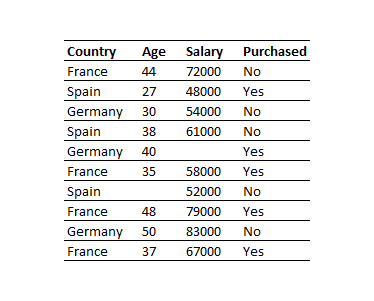

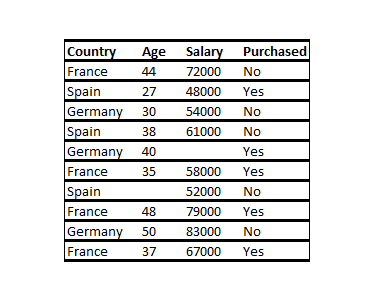

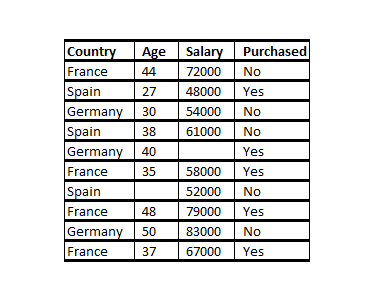

           0     1        2           3
0    Country   Age   Salary   Purchased
1     France    44    72000          No
2      Spain    27    48000         Yes
3    Germany    30    54000          No
4      Spain    38    61000          No
5    Germany    40                  Yes
6     France    35    58000         Yes
7      Spain          52000          No
8     France    48    79000         Yes
9    Germany    50    83000          No
10    France    37    67000         Yes
Output excel generated as  tab_hor2_output.xlsx


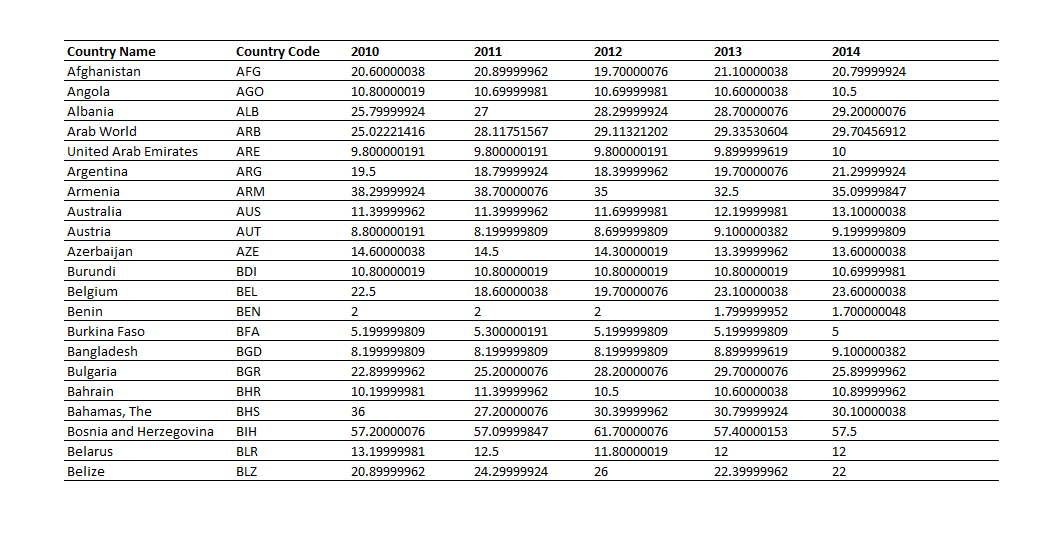

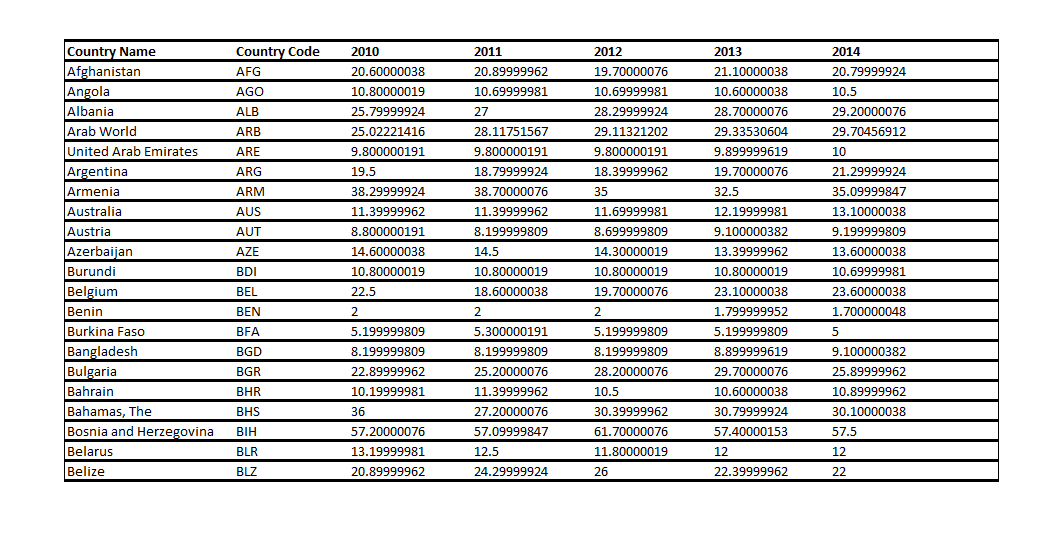

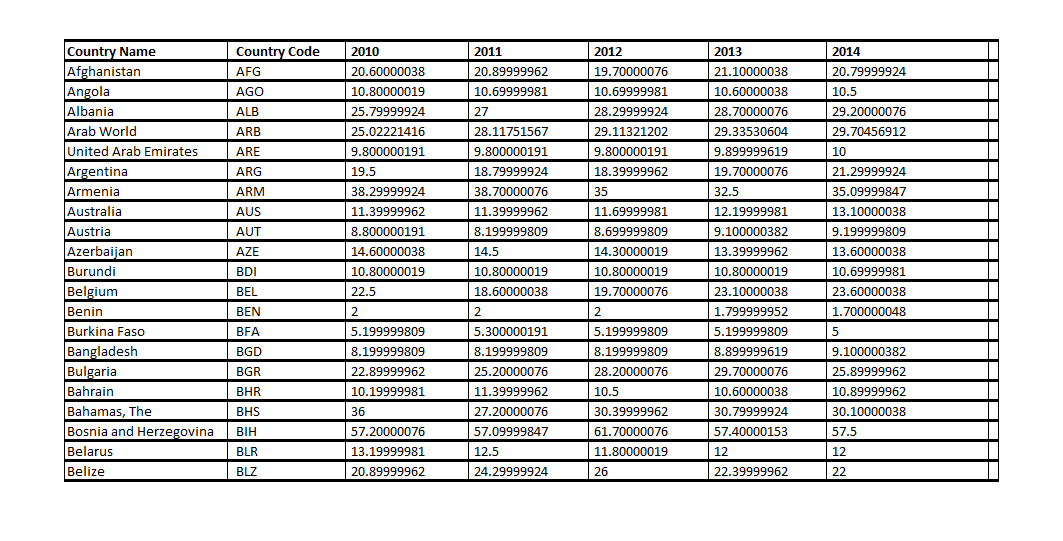

                          0              1  ...             6  7
0              Country Name   Country Code  ...          2014   
1               Afghanistan            AFG  ...   20.79999924   
2                    Angola            AGO  ...          10.5   
3                   Albania            ALB  ...   29.20000076   
4                Arab World            ARB  ...   29.70456912   
5      United Arab Emirates            ARE  ...            10   
6                 Argentina            ARG  ...   21.29999924   
7                   Armenia            ARM  ...   35.09999847   
8                 Australia            AUS  ...   13.10000038   
9                   Austria            AUT  ...   9.199999809   
10               Azerbaijan            AZE  ...   13.60000038   
11                  Burundi            BDI  ...   10.69999981   
12                  Belgium            BEL  ...   23.60000038   
13                    Benin            BEN  ...   1.700000048   
14             Burkina Fa

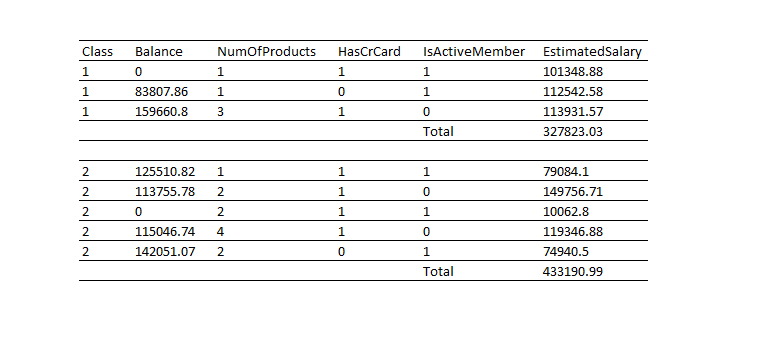

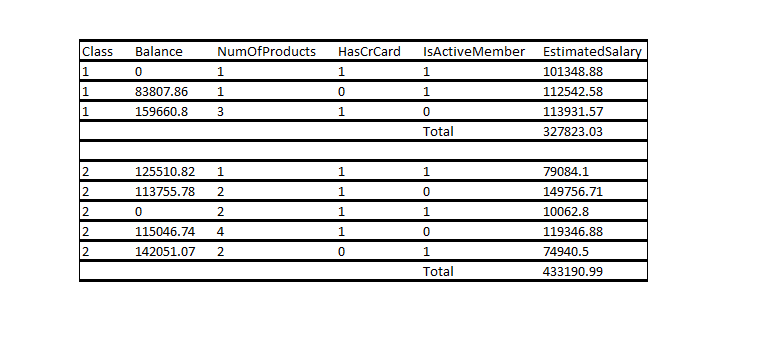

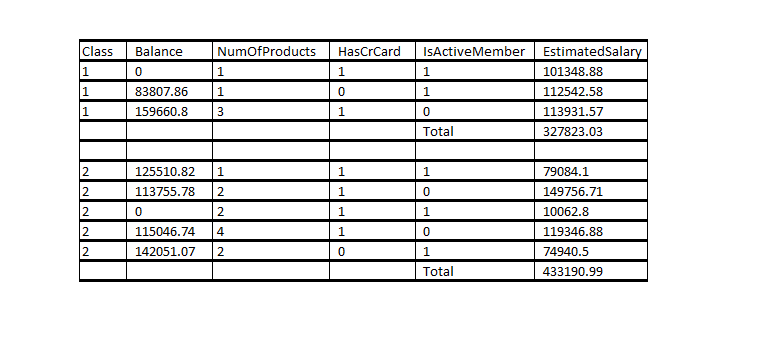

         0           1  ...                4                 5
0    Class     Balance  ...   IsActiveMember   EstimatedSalary
1        1           0  ...                1         101348.88
2        1    83807.86  ...                1         112542.58
3        1    159660.8  ...                0         113931.57
4                       ...            Total         327823.03
5                       ...                                   
6        2   125510.82  ...                1           79084.1
7        2   113755.78  ...                0         149756.71
8        2           0  ...                1           10062.8
9        2   115046.74  ...                0         119346.88
10       2   142051.07  ...                1           74940.5
11                      ...            Total         433190.99

[12 rows x 6 columns]
Output excel generated as  tab_hor4_output.xlsx


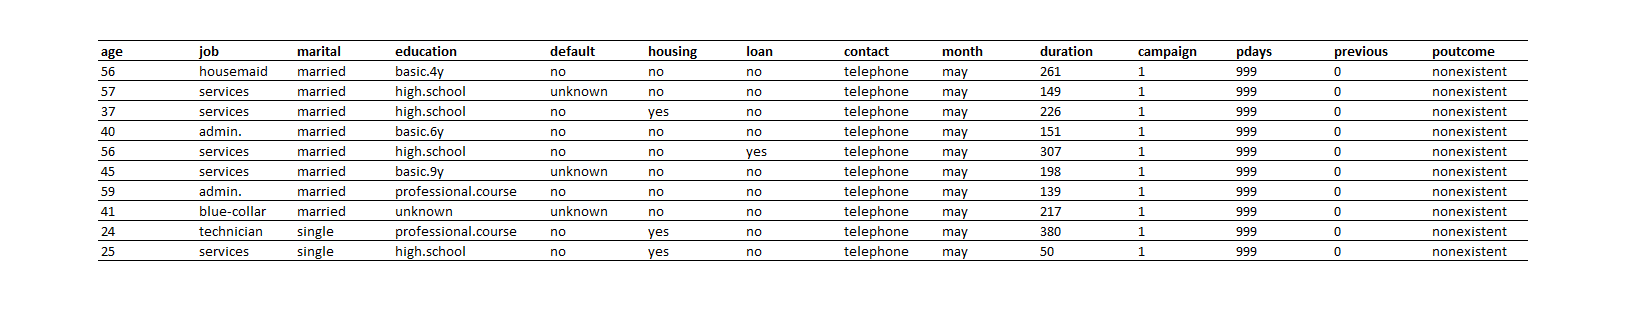

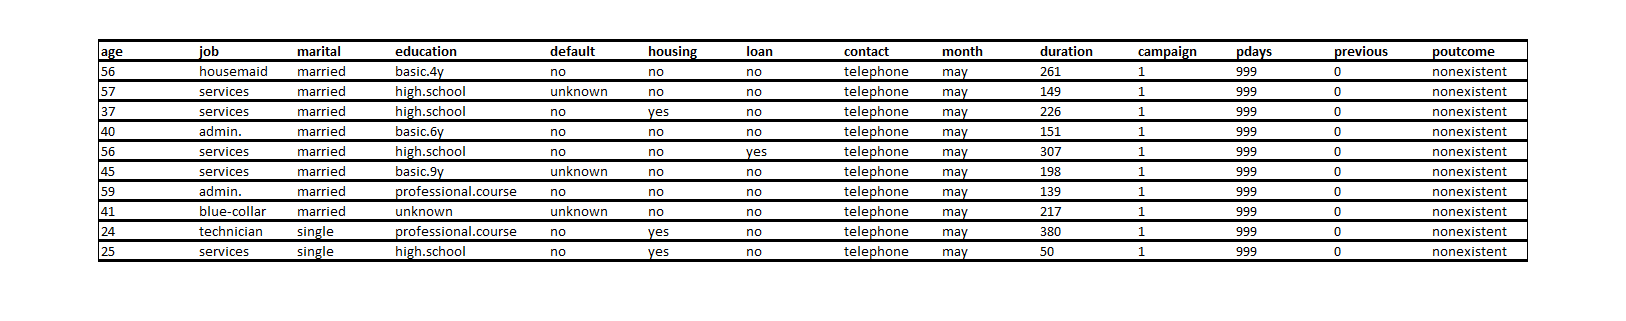

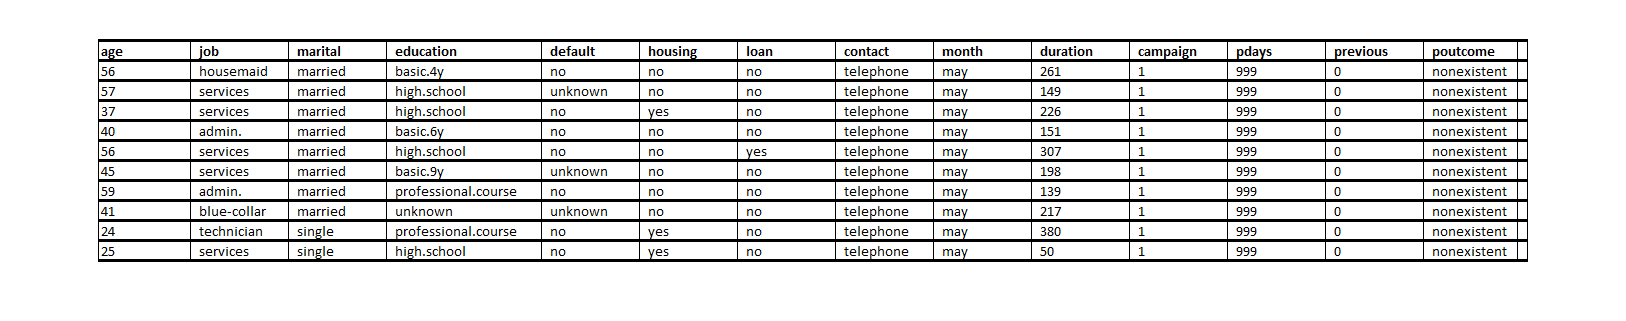

      0             1         2   ...         12            13 14
0    age           job   marital  ...   previous      poutcome   
1     56     housemaid   married  ...          0   nonexistent   
2     57      services   married  ...          0   nonexistent   
3     37      services   married  ...          0   nonexistent   
4     40        admin.   married  ...          0   nonexistent   
5     56      services   married  ...          0   nonexistent   
6     45      services   married  ...          0   nonexistent   
7     59        admin.   married  ...          0   nonexistent   
8     41   blue-collar   married  ...          0   nonexistent   
9     24    technician    single  ...          0   nonexistent   
10    25      services    single  ...          0   nonexistent   

[11 rows x 15 columns]
Output excel generated as  tab_hor6_output.xlsx


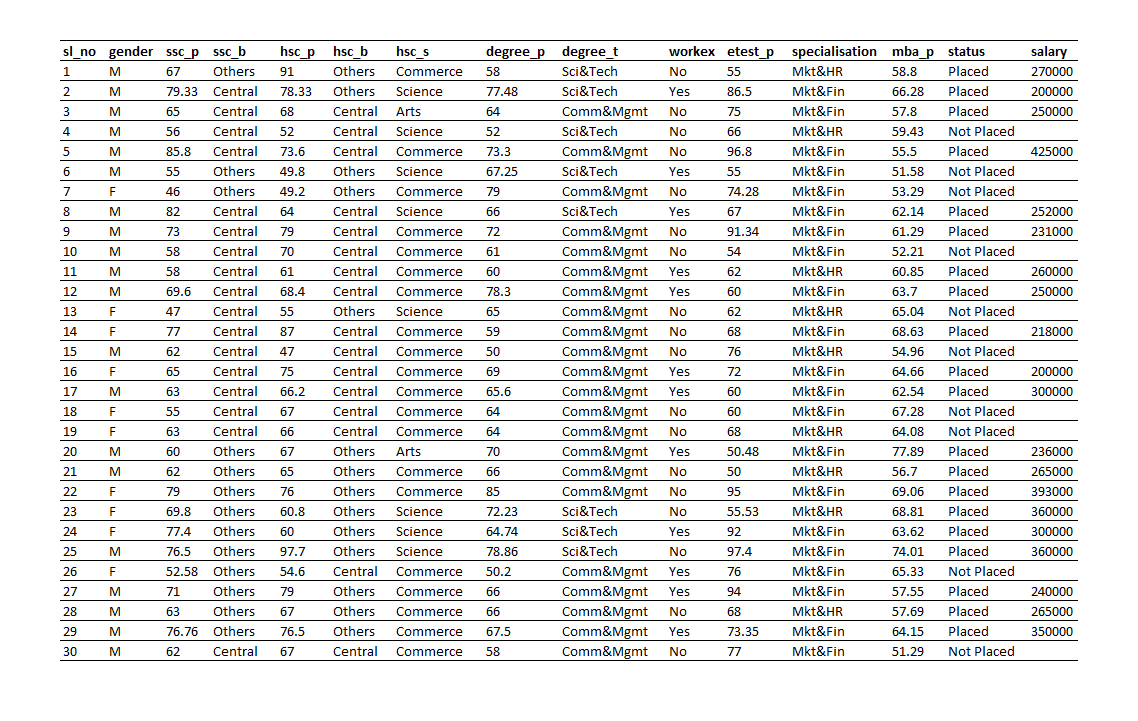

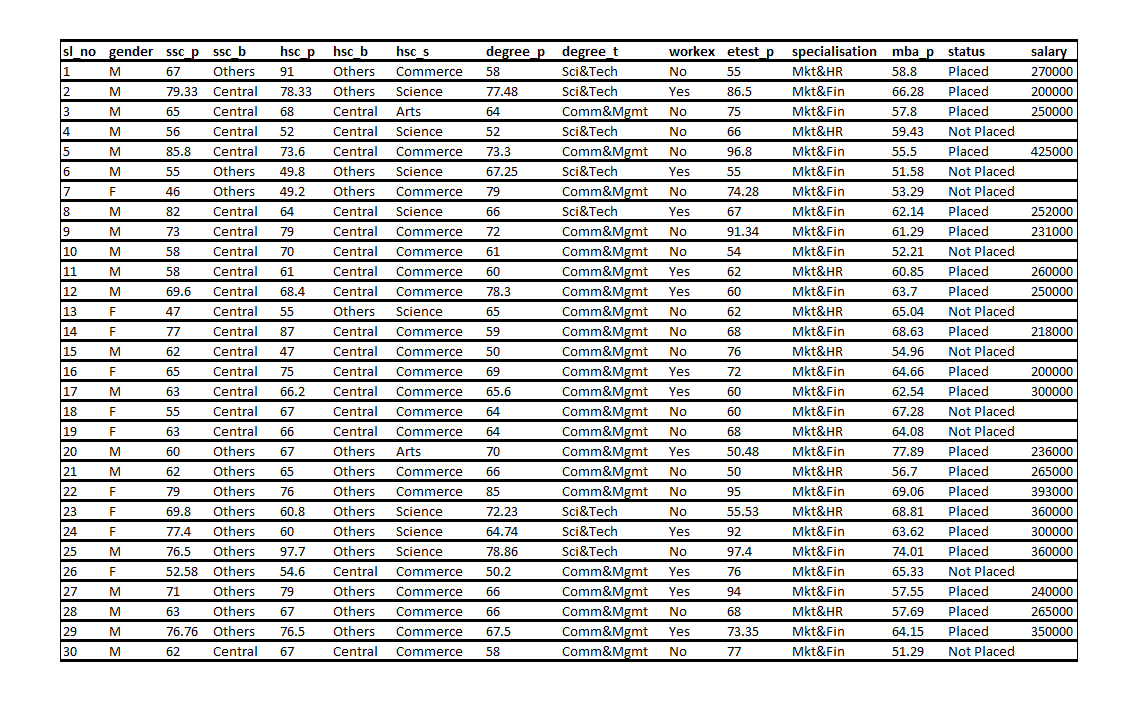

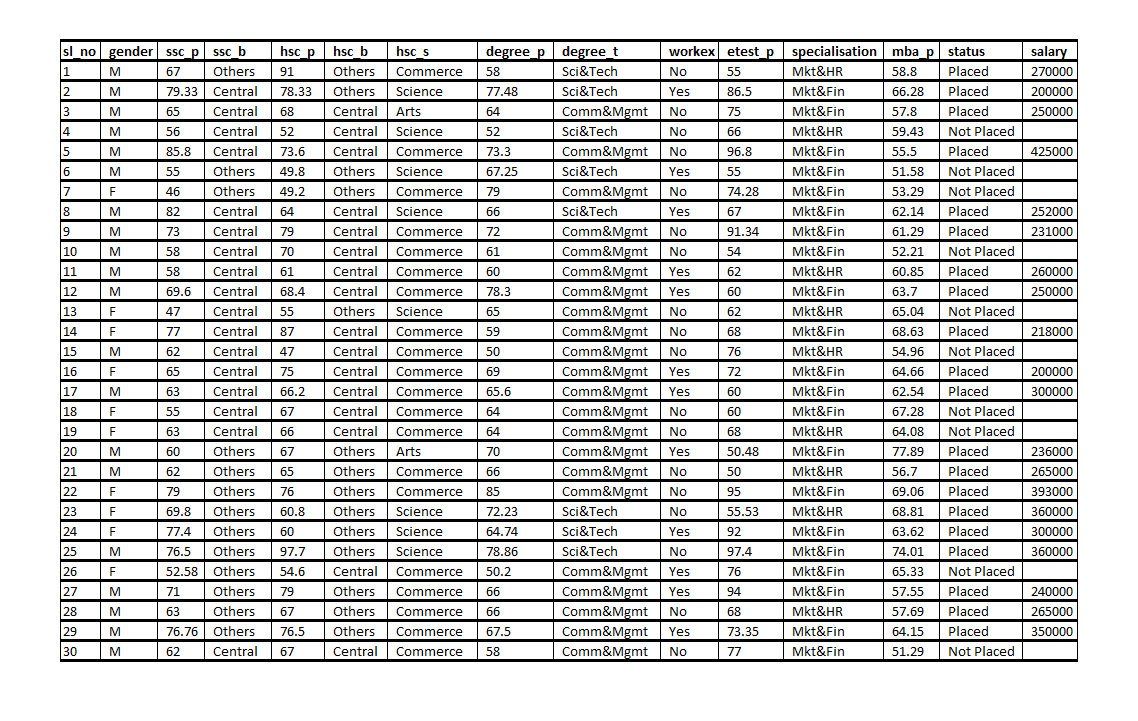

        0        1       2   ...      12           13       14
0    sl_no   gender   ssc p  ...   mba p       status   salary
1        1        M      67  ...    58.8       Placed   270000
2        2        M   79.33  ...   66.28       Placed   200000
3        3        M      65  ...    57.8       Placed   250000
4        4        M      56  ...   59.43   Not Placed         
5        5        M    85.8  ...    55.5       Placed   425000
6        6        M      55  ...   51.58   Not Placed         
7        7        F      46  ...   53.29   Not Placed         
8        8        M      82  ...   62.14       Placed   252000
9       93        M      73  ...   61.29       Placed   231000
10      10        M      58  ...   52.21   Not Placed         
11      11        M      58  ...   60.85       Placed   260000
12      12        M    69.6  ...    63.7       Placed   250000
13      13        F      47  ...   65.04   Not Placed         
14      14        F      77  ...   68.63       Placed  

In [ ]:
tableNames = ['tab_hor2.png','tab_hor3.png','tab_hor4.png','tab_hor6.png', 'tab_hor8.png']
# tableNames = ['tab_hor2.png']

for tableName in tableNames:
  getNonBorderedTableInfo(tableName)
  print('Output excel generated as ', tableName.split('.')[0] + '_output.xlsx') 

In [ ]:
def getNonBorderedTableInfo(filename):
  #read your image file
  # filename = 'tab_hor3.png'
  filenameComp = filename.split('.')
  file=filename
  img = cv2.imread(file)
  cv2_imshow(img) 
  img, yCor_line_map = addOuterBorders(img,filenameComp)
  delimiters = getColDelimiters(img, yCor_line_map,filenameComp)
  bordered_img = get_bordered_Image(delimiters, yCor_line_map, img)
  cv2_imshow(bordered_img)
  cv2.imwrite(filenameComp[0] + '_all_borders.png', bordered_img) 
  borderedTableName = filenameComp[0] + '_all_borders.png'
  convertTableImageToCsv(borderedTableName)

In [ ]:
cv2_imshow(borderedTable)

In [ ]:
# borderedTableName = filenameComp[0] + '_all_borders.png'
convertTableImageToCsv(borderedTableName)

# Find the output excel with the following name:-
# '<borderedTable>_output.xlsx'

In [ ]:
# print(borderedTableName)
files.download('tab_hor8_all_borders_output.xlsx') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!ls

horizontal.jpg			   tab_hor4_cropped_header.png
sample_data			   tab_hor4_ext_bordered.png
tab_hor2_all_borders_inverted.png  tab_hor4.png
tab_hor2_all_borders_output.xlsx   tab_hor6_all_borders_inverted.png
tab_hor2_all_borders.png	   tab_hor6_all_borders_output.xlsx
tab_hor2_cropped_header.png	   tab_hor6_all_borders.png
tab_hor2_ext_bordered.png	   tab_hor6_cropped_header.png
tab_hor2.png			   tab_hor6_ext_bordered.png
tab_hor3_all_borders_inverted.png  tab_hor6.png
tab_hor3_all_borders_output.xlsx   tab_hor8_all_borders_inverted.png
tab_hor3_all_borders.png	   tab_hor8_all_borders_output.xlsx
tab_hor3_cropped_header.png	   tab_hor8_all_borders.png
tab_hor3_ext_bordered.png	   tab_hor8_cropped_header.png
tab_hor3.png			   tab_hor8_ext_bordered.png
tab_hor4_all_borders_inverted.png  tab_hor8.png
tab_hor4_all_borders_output.xlsx   vertical.jpg
tab_hor4_all_borders.png
